In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# ...pipeline cell to build YOY plot...

# pull data
aiid_data = pd.read_csv("./src/aiid_data_pull_20231213.csv")

# convert type of date field
aiid_data['date'] = aiid_data['date'].astype('datetime64[ns]')

# add day, month, and year to data
datetimes = pd.to_datetime(aiid_data['date'])

aiid_data['day'] = datetimes.dt.day
aiid_data['month'] = datetimes.dt.month
aiid_data['year'] = datetimes.dt.year

/var/folders/qy/2qlsgz6s43xbn14whr8v3sbh0000gn/T/ipykernel_5167/2060308464.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aiid_data['date'] = aiid_data['date'].astype('datetime64[ns]')


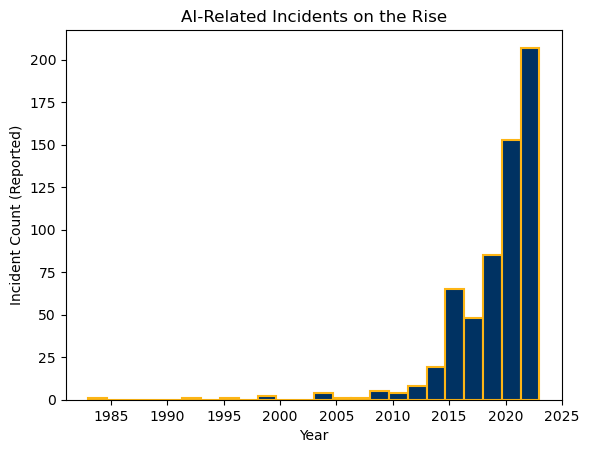

In [3]:
# show incidents year over year

# use berkeley colors
bar_color = '#003262'
outline_color = '#FDB515'

plt.hist(aiid_data['year'],
         bins=len(aiid_data['year'].unique()),
         color=bar_color,      # Set the hex color for bars
         edgecolor=outline_color,  # Set the hex color for bar outlines
         linewidth=1.5)       # Adjust the linewidth as needed

plt.title('AI-Related Incidents on the Rise')
plt.xlabel('Year')
plt.ylabel('Incident Count (Reported)')
plt.show()

In [4]:
# ...pipeline cell to build harmed parties plot...

# make verbiage more consistent
aiid_data['alleged_harmed_or_nearly_harmed_parties'] = aiid_data['alleged_harmed_or_nearly_harmed_parties'].str.replace(', ', ',').str.strip()

# Extract numeric part and convert to integers
aiid_data['id_num'] = aiid_data['id'].str.extract(r'(\d+)').astype(int)

# Move 'id_num' to the first position
aiid_data = aiid_data[['id_num'] + [col for col in aiid_data.columns if col != 'id_num']]

# Sort by id_num
aiid_data.sort_values('id_num', inplace=True)

# create dataframe for unique harmed parties
aiid_data_unique_harmed = pd.DataFrame(columns=aiid_data.columns)

for _, row in aiid_data.iterrows():
    harmed_parties = row['alleged_harmed_or_nearly_harmed_parties'].split(',')
    
    for party in harmed_parties:
        new_row = row.copy()
        new_row['alleged_harmed_or_nearly_harmed_parties'] = party.strip().lower()
        aiid_data_unique_harmed = pd.concat([aiid_data_unique_harmed, pd.DataFrame([new_row])], ignore_index=True)

# Sort the DataFrame by 'id_num' and reset the index
aiid_data_unique_harmed.sort_values('id_num', inplace=True)
aiid_data_unique_harmed.reset_index(drop=True, inplace=True)

### Split the values in the 'alleged_harmed_or_nearly_harmed_parties' column
# and stack them into a new DataFrame
aiid_data_unique_harmed_counts = aiid_data_unique_harmed['alleged_harmed_or_nearly_harmed_parties']

# Rename the resulting Series to 'alleged_harmed_or_nearly_harmed_party'
aiid_data_unique_harmed_counts.name = 'alleged_harmed_or_nearly_harmed_party'

# Count the occurrences of each party
harmed_party_occurrences = aiid_data_unique_harmed_counts.value_counts()

# Display the result
harmed_party_occurrences_df = pd.DataFrame(harmed_party_occurrences).reset_index()

In [5]:
# create mapping dictionary for harmed parties
mapping_dict = {
    'general public': 'general_public',
    'user': 'platform_users_customers',
    'users': 'platform_users_customers',
    'customer': 'platform_users_customers',
    'children': 'minors',
    'child': 'minors',
    'minors': 'minors',
    'teenagers': 'minors',
    'black': 'minority_groups',
    'latinx': 'minority_groups',
    'jewish': 'minority_groups',
    'women': 'minority_groups',
    'female': 'minority_groups',
    'non-male': 'minority_groups',
    'gender minority groups': 'minority_groups',
    'transgender': 'minority_groups',
    'non-binary': 'minority_groups',
    'gay': 'minority_groups',
    'african': 'minority_groups',
    'haitian': 'minority_groups',
    'black patients': 'minority_groups',
    'communities of color': 'minority_groups',
    'black students': 'minority_groups',
    'neighborhoods of color': 'minority_groups',
    'minority': 'minority_groups',
    'minorities': 'minority_groups',
    'non-Caucasian': 'minority_groups',
    'non-white': 'minority_groups',
    'low-income communities': 'minority_groups',
    'bipoc': 'minority_groups',
    'indigenous': 'minority_groups',
    'brown communities': 'minority_groups',
    'disab': 'minority_groups',
    'traffic participants': 'traffic_participants',
    'drivers': 'traffic_participants',
    'pedestrians': 'traffic_participants',
    'motorists': 'traffic_participants',
    'openai': 'developer_of_ai_system',
    'microsoft': 'developer_of_ai_system'
}

def map_categories(text):
    for term, category in mapping_dict.items():
        if term in text:
            return category
    return text

# apply the mapping function above with associated mapped categories
aiid_data_unique_harmed['alleged_harmed_or_nearly_harmed_generalized'] = aiid_data_unique_harmed['alleged_harmed_or_nearly_harmed_parties'].apply(map_categories)

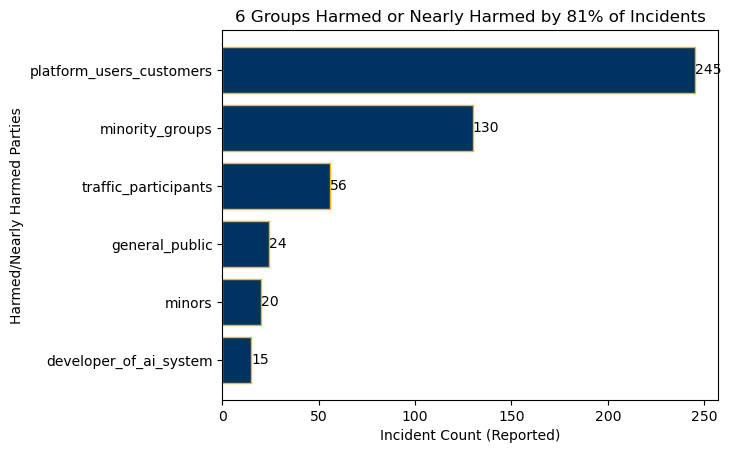

In [6]:
# plot with berkeley colors
bar_color = '#003262'
outline_color = '#FDB515'

# Count occurrences of each unique value in the 'alleged_developer_of_ai_system' column
harmed_counts = aiid_data_unique_harmed['alleged_harmed_or_nearly_harmed_generalized'].value_counts()

# Drop the entry where the alleged developer is "unknown"
harmed_counts = harmed_counts.drop('unknown', errors='ignore')

# Select the top 6 values (including ties)
top_harmed = harmed_counts.head(6)

# Create a horizontal bar chart with the largest value at the top
plt.barh(top_harmed.index[::-1],
         top_harmed[::-1],
         color=bar_color,      # Set the hex color for bars
         edgecolor=outline_color)  # Set the hex color for bar outlines

for index, value in zip(top_harmed.index[::-1], top_harmed[::-1]):
    plt.text(value, index, str(value), va='center')

# Add labels and title
plt.xlabel('Incident Count (Reported)')
plt.ylabel('Harmed/Nearly Harmed Parties')
plt.title('6 Groups Harmed or Nearly Harmed by 81% of Incidents')

# Display the plot
plt.show()

partial_string = 'location'
aiid_search = aiid_data[aiid_data['description'].str.contains(partial_string, case=False)]
pd.set_option('display.max_colwidth', None)
#aiid_search.head(4)

In [7]:
# alleged_developer_of_ai_system has columns with multiple companies,
# I want to split them out to get the total count for each
aiid_data_unique_dev = pd.DataFrame(columns=aiid_data.columns)

for _, row in aiid_data.iterrows():
    alleged_dev = row['alleged_developer_of_ai_system'].split(',')
    
    for dev in alleged_dev:
        new_row = row.copy()
        new_row['alleged_developer_of_ai_system'] = dev.strip().lower()
        aiid_data_unique_dev = pd.concat([aiid_data_unique_dev, pd.DataFrame([new_row])], ignore_index=True)

# Sort the DataFrame by 'id_num' and reset the index
aiid_data_unique_dev.sort_values('id_num', inplace=True)
aiid_data_unique_dev.reset_index(drop=True, inplace=True)


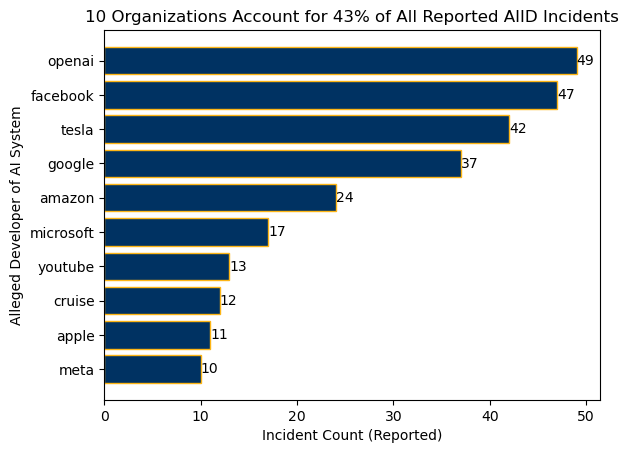

In [8]:
# plot with berkeley colors

bar_color = '#003262'
outline_color = '#FDB515'

# Count occurrences of each unique value in the 'alleged_developer_of_ai_system' column
developer_counts = aiid_data_unique_dev['alleged_developer_of_ai_system'].value_counts()

# Drop the entry where the alleged developer is "unknown"
developer_counts = developer_counts.drop('unknown', errors='ignore')

# Select the top 10 values (including ties)
top_developers = developer_counts.head(10)

# Create a horizontal bar chart with the largest value at the top
plt.barh(top_developers.index[::-1],
         top_developers[::-1],
         color=bar_color,  # Set the hex color for bar outlines
         edgecolor=outline_color)  # Set the hex color for bar outlines


for index, value in zip(top_developers.index[::-1], top_developers[::-1]):
    plt.text(value, index, str(value), va='center')

# Add labels and title
plt.xlabel('Incident Count (Reported)')
plt.ylabel('Alleged Developer of AI System')
plt.title('10 Organizations Account for 43% of All Reported AIID Incidents')

# Display the plot
plt.show()
